In [2]:
%load_ext autoreload
%autoreload 2

In [984]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as sct
from generate_sample import SampleGenerator

from sklearn.metrics import roc_auc_score, roc_curve

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [520]:
from functools import partial, reduce

In [998]:
np.set_printoptions(precision=2)
sns.set_style('darkgrid')

# Generate data

In [944]:
n_samples = 100
t_mat = np.array([[0.8, 0.2],[0.2, 0.8]])
init = 0

sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 10}], 2, 
                     t_mat)
vals, states_orig = sg.generate_samples(n_samples, init_state=init)

In [945]:
states_orig

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0])

In [946]:
vals

array([ 3,  3,  3,  9, 11,  7, 10,  8,  4,  5,  3,  5,  3,  5, 11, 14,  6,
        5,  6,  2,  8,  3,  4, 12,  5,  3,  6,  9, 12, 19,  8,  2, 10,  9,
        8, 10,  7,  4,  8,  5, 18,  6, 13, 16, 15,  6,  8, 14,  3,  7, 13,
        6,  4,  4,  5,  8,  5, 11, 15, 15,  3,  5,  5,  5,  2,  1,  4,  8,
        6, 10,  3, 11, 11, 12, 14,  5,  6,  5, 15, 19, 14, 12,  7,  8,  4,
        2,  4,  3, 15,  6, 14, 10, 11,  4,  4,  4,  4, 11, 13,  1])

# Forward-Backward algorithm

## Forward algorithm

In [960]:
def normalize(mat, axis=None):
    c = mat.sum(axis=axis)
    if axis==1:
        c = c.reshape(-1, 1)
    elif axis == 0:
        c = c.reshape(1, -1)
        
    return c, mat / c

In [959]:
def forward_pass(y, t, dists, init, trans_mat):
    
    x0 = dists[0]
    x1 = dists[1]
    all_c = []
    if t == 0:
        O = np.diag([x0.pmf(y[0]), x1.pmf(y[0])])
        c, normed = normalize(O @ init)
        return c, normed.reshape(1, -1)
        
    else:
        c_tm1, alpha_tm1 = forward_pass(y, t - 1, dists, init, trans_mat)
        
        O = np.diag([x0.pmf(y[t]), x1.pmf(y[t])])
        c, normed = normalize(O @ trans_mat.T @ alpha_tm1[-1, :])
        
        return c_tm1 + c, np.row_stack([alpha_tm1, normed])
        

In [961]:
X = states_orig
y = vals
t = n_samples - 1
dists = sct.poisson(5), sct.poisson(10)
init = np.array([1, 0])
trans_mat = t_mat

consts, state_prob_forward = forward_pass(y, t, dists, init, trans_mat)

In [962]:
roc_auc_score(X[:t+1], state_prob_forward[:,1])

0.9604

In [1045]:
def plot_roc(y_true, y_pred, title, ax=None):
    
    if ax == None:
        f, ax = plt.subplots(figsize=(7,5))
        
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, label=title + " ({:.2f})".format(auc))
    
    plt.legend(loc=4)
    return ax

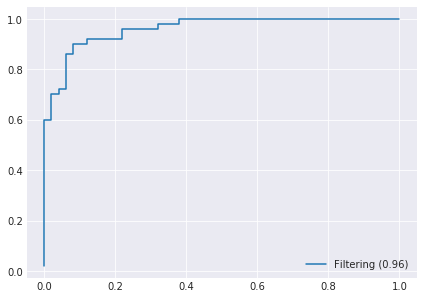

In [1046]:
plot_roc(X, state_prob_forward[:,1], "Filtering", ax=None)

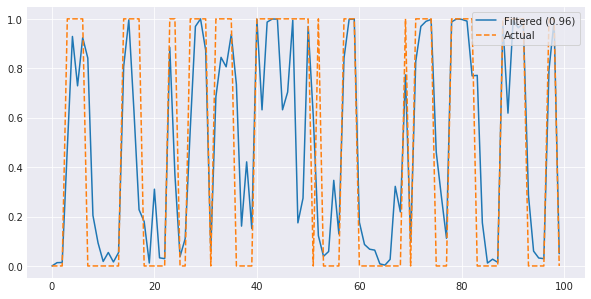

In [1076]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, state_prob_forward[:,1])
ax.plot(state_prob_forward[:,1], label ='Filtered ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)

plt.savefig("../../../sidravi1.github.io/assets/2019-02-25_filtered.png")

## Backward algorithm

In [963]:
def backward_pass(y, T, t, dists, init, trans_mat):
    
    x0 = dists[0]
    x1 = dists[1]
    all_c = []
    
    if t == T:
        c, normed = normalize(np.ones(2))
        return 0, normed.reshape(1, -1)
        #return 0, np.ones(2).reshape(1, -1)
    else:
        
        c_tm1, beta_tp1 = backward_pass(y, T, t+1, dists, init, trans_mat)
        O = np.diag([x0.pmf(y[t+1]), x1.pmf(y[t+1])])
        c, normed = normalize(trans_mat @ O @ beta_tp1[-1, :])
        
        return c_tm1 + c, np.row_stack([normed, beta_tp1])


In [964]:
c, state_prob_backward = backward_pass(y, 99, 0, dists, init, trans_mat)

In [965]:
roc_auc_score(X[:t+1], state_prob_backward[:,1])

0.6958

## Forward-backward algorithm

In [967]:
def gamma_pass(y, T, t, dists, init, trans_mat):
    
    consts_f, state_prob_forward = forward_pass(y, T, dists, init, trans_mat)
    consts_b, state_prob_backward = backward_pass(y, T, t, dists, init, trans_mat)
    
    gamma = (state_prob_backward * state_prob_forward)
    
    return gamma

In [968]:
gamma = gamma_pass(y, 99, 0, dists, init, trans_mat)
pred = np.divide(gamma, gamma.sum(axis=1).reshape(-1,1))
roc_auc_score(X[:t+1], pred[:,1])

0.9667999999999999

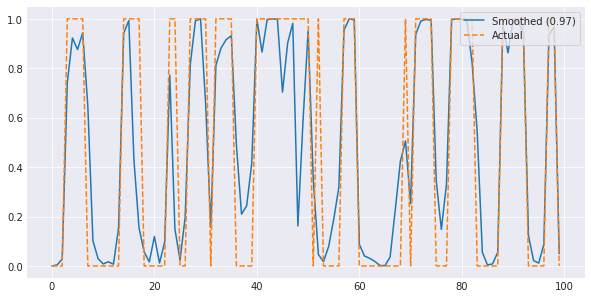

In [1075]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, pred[:,1])
ax.plot(pred[:,1], label ='Smoothed ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)

plt.savefig("../../../sidravi1.github.io/assets/2019-02-25_smoothed.png")

## Two-slice marginal

In [969]:
def two_slice(y, T, t, dists, init, trans_mat):
    
    _, betas = backward_pass(y, T, t, dists, init, trans_mat)
    _, alphas = forward_pass(y, t-1, dists, init, trans_mat) 
    
    alpha = alphas[-1]
    beta = betas[0]
    
    O = np.diag([x0.pmf(y[t]), x1.pmf(y[t])])
    
    c, normed = normalize(trans_mat * (alpha @ (O * beta).T), axis=None)
    
    return c, normed
    

In [970]:
c, normed = two_slice(y, 99, 5, dists, init, trans_mat)
normed

array([[0.02625342, 0.19343665],
       [0.00656335, 0.77374658]])

# EM (Baum-Welch)

## Intialize

In [973]:
pi_init = npr.dirichlet(alpha=[0.5, 0.5])
z_init = npr.randint(0, 2, size=n_samples)
A_init = npr.dirichlet(alpha=[3, 3], size=2)
B_init = np.array([1, 20])

# E-step

In [974]:
z = z_init.copy()
A = A_init.copy()
B = B_init.copy()
pi = pi_init.copy()

print(A, B, pi)

[[0.47855527 0.52144473]
 [0.53304532 0.46695468]] [ 1 20] [0.10864598 0.89135402]


In [975]:
def E_step(y, A, B, pi):
    
    dists = sct.poisson(B[0]), sct.poisson(B[1])
    
    all_gammas = gamma_pass(y, 99, 0, dists, pi, A)

    En1k = all_gammas[0]
    Enjk = reduce(lambda x,y : x+y, map(lambda t: two_slice(y, 99, t, dists, pi, A)[1], range(1, 100)))
    Enj = reduce(lambda x,y: x + y, all_gammas)
    
    first_term = En1k @ np.log(pi) 
    middle_term = (Enjk * np.log(A)).sum()
    
    p_z = np.log(np.row_stack([dists[0].pmf(y), dists[1].pmf(y)]))
    final_term = (p_z * all_gammas.T).sum()
    
    like = first_term + middle_term + final_term
    
    return like, En1k, Enjk, Enj, all_gammas

In [976]:
def M_step(y, En1k, Enjk, Enj, all_gammas):

    A = Enjk / Enjk.sum(axis=1).reshape(-1, 1) 
    pi = En1k / En1k.sum()
    
    B = (all_gammas * y.reshape(-1, 1)).sum(axis=0) / Enj    

    return A, np.round(B), pi

In [1018]:
np.random.seed(55)

max_iter = 100
i = 0

pi_init = np.array([0.5, 0.5]) #npr.dirichlet(alpha=[0.5, 0.5])
z_init = npr.randint(0, 2, size=n_samples)
A_init = npr.dirichlet(alpha=[0.5, 0.5], size=2)
B_init = np.array([1, 20])

z = z_init.copy()
A = A_init.copy()
B = B_init.copy()
pi = pi_init.copy()

like_new = 1e10
like_old = 1e-10

print("\n A_init:{}, B_init:{}, pi_init:{}".format(A, B, pi))
print("----------------------")
while (np.abs(like_new - like_old) > 1e-5) and (i < max_iter):
    if ((i % 10) == 0) and (i > 0):
        print("\n A:{}, B:{}, pi:{}, ll:{:0.2f}".format(A, B, pi, like))
        all_gammas2 = all_gammas/all_gammas.sum(axis=1).reshape(-1,1)
        print("{:0.2f}".format(roc_auc_score(X[:100], all_gammas2[:,1])))
    else:
        print(".", end="")
    like, En1k, Enjk, Enj, all_gammas = E_step(y, A, B, pi)
    like_old = like_new
    like_new = like
    A, B, pi = M_step(y, En1k, Enjk, Enj, all_gammas)
    
    i += 1



 A_init:[[0.75 0.25]
 [0.07 0.93]], B_init:[ 1 20], pi_init:[0.5 0.5]
----------------------
..........
 A:[[0.76 0.24]
 [0.08 0.92]], B:[ 4. 11.], pi:[1.0e+00 1.2e-29], ll:-170.78
0.97
.........
 A:[[0.76 0.24]
 [0.08 0.92]], B:[ 4. 11.], pi:[1.00e+00 8.03e-56], ll:-170.78
0.97
...

In [1019]:
all_gammas2 = all_gammas/all_gammas.sum(axis=1).reshape(-1,1)

In [1073]:
pi

array([1.00e+00, 2.73e-66])

In [1020]:
roc_auc_score(X, all_gammas2[:,1])

0.9664

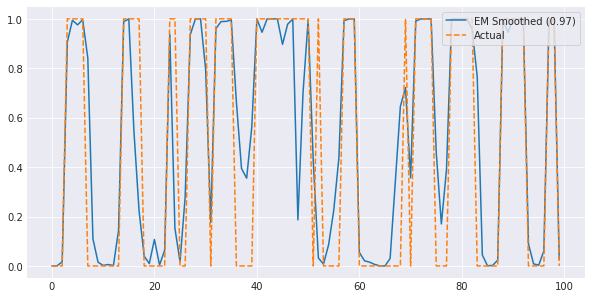

In [1074]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, all_gammas2[:,1])
ax.plot(all_gammas2[:,1], label ='EM Smoothed ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)

plt.savefig("../../../sidravi1.github.io/assets/2019-02-25_EM_smoothed.png")

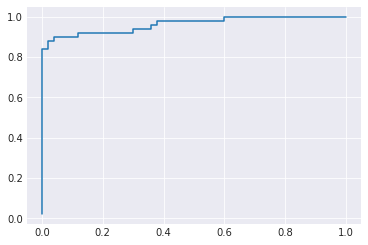

In [992]:
sns.set_style('darkgrid')
fpr, tpr, threshold = roc_curve(X, all_gammas2[:,1])
plt.plot(fpr, tpr)